DENSENET --GRADE LEVEL

In [ ]:
import zipfile
import os

ZIP_PATH = "/content/Grades.zip"
BASE_PATH = "/content/dfu_data/"


In [ ]:
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(BASE_PATH)
print("✅ Dataset extracted")

✅ Dataset extracted


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
BASE_PATH = "/content/dfu_data/archive (5)"

TRAIN_PATH = BASE_PATH + "/train"
VALID_PATH = BASE_PATH + "/valid"
TEST_PATH  = BASE_PATH + "/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 4


In [ ]:
def count_images(path):
    print(f"\n📂 {path}")
    total = 0
    for cls in sorted(os.listdir(path)):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            n = len(os.listdir(cls_path))
            total += n
            print(f"  {cls}: {n}")
    print(f"  ✅ Total: {total}")

count_images(TRAIN_PATH)
count_images(VALID_PATH)
count_images(TEST_PATH)



📂 /content/dfu_data/archive (5)/train
  Grade 1: 2240
  Grade 2: 2345
  Grade 3: 2744
  Grade 4: 2310
  ✅ Total: 9639

📂 /content/dfu_data/archive (5)/valid
  Grade 1: 86
  Grade 2: 78
  Grade 3: 40
  Grade 4: 78
  ✅ Total: 282

📂 /content/dfu_data/archive (5)/test
  Grade 1: 44
  Grade 2: 37
  Grade 3: 18
  Grade 4: 42
  ✅ Total: 141


In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

valid_data = val_test_gen.flow_from_directory(
    VALID_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_data = val_test_gen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 9639 images belonging to 4 classes.
Found 282 images belonging to 4 classes.
Found 141 images belonging to 4 classes.


In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_data.classes),
    y=train_data.classes
)

class_weights = dict(enumerate(class_weights))
print("\n📊 Class Weights:", class_weights)



📊 Class Weights: {0: np.float64(1.07578125), 1: np.float64(1.0276119402985076), 2: np.float64(0.8781887755102041), 3: np.float64(1.0431818181818182)}


In [ ]:
inputs = Input(shape=(224, 224, 3))

base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_tensor=inputs
)

base_model.trainable = False  # freeze initially

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

dfu_model = Model(inputs, outputs)

dfu_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

dfu_model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,564,356 (28.86 MB)

 Trainable params: 526,852 (2.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_stage1 = dfu_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 206s 291ms/step - accuracy: 0.3580 - loss: 1.4518 - val_accuracy: 0.5319 - val_loss: 1.0962
Epoch 2/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 137s 228ms/step - accuracy: 0.5016 - loss: 1.1353 - val_accuracy: 0.5745 - val_loss: 1.0449
Epoch 3/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 138s 228ms/step - accuracy: 0.5392 - loss: 1.0519 - val_accuracy: 0.5780 - val_loss: 1.0233
Epoch 4/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 140s 231ms/step - accuracy: 0.5654 - loss: 1.0143 - val_accuracy: 0.5674 - val_loss: 1.0212
Epoch 5/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 140s 232ms/step - accuracy: 0.5826 - loss: 0.9768 - val_accuracy: 0.6028 - val_loss: 1.0182
Epoch 6/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 138s 228ms/step - accuracy: 0.5976 - loss: 0.9514 - val_accuracy: 0.5887 - val_loss: 1.0098
Epoch 7/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 138s 228ms/step - accuracy: 0.6080 - loss: 0.9172 - val_accuracy: 0.5957 - val_loss: 0.9949
Epoch 8/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 138s 228ms/step - accuracy: 0.6224 -

In [ ]:
for layer in base_model.layers[-80:]:
    layer.trainable = True

dfu_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # VERY IMPORTANT
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_stage2 = dfu_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 239s 318ms/step - accuracy: 0.5361 - loss: 1.1034 - val_accuracy: 0.6099 - val_loss: 1.0064
Epoch 2/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 142s 235ms/step - accuracy: 0.5954 - loss: 0.9458 - val_accuracy: 0.6028 - val_loss: 0.9965
Epoch 3/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 140s 232ms/step - accuracy: 0.6212 - loss: 0.9011 - val_accuracy: 0.6064 - val_loss: 0.9889
Epoch 4/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 139s 230ms/step - accuracy: 0.6397 - loss: 0.8603 - val_accuracy: 0.6170 - val_loss: 0.9877
Epoch 5/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 139s 230ms/step - accuracy: 0.6666 - loss: 0.8028 - val_accuracy: 0.6241 - val_loss: 0.9878
Epoch 6/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 139s 231ms/step - accuracy: 0.6856 - loss: 0.7793 - val_accuracy: 0.6277 - val_loss: 0.9956
Epoch 7/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 148s 245ms/step - accuracy: 0.6908 - loss: 0.7654 - val_accuracy: 0.6206 - val_loss: 1.0018
Epoch 8/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 138s 229ms/step - accuracy: 0.6994 -

9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step

📊 Classification Report (TEST SET)

              precision    recall  f1-score   support

     Grade 1       0.61      0.61      0.61        44
     Grade 2       0.62      0.54      0.58        37
     Grade 3       0.56      0.56      0.56        18
     Grade 4       0.70      0.79      0.74        42

    accuracy                           0.64       141
   macro avg       0.62      0.62      0.62       141
weighted avg       0.64      0.64      0.64       141



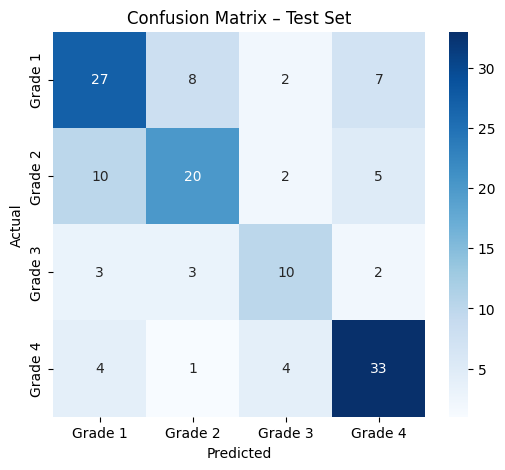

In [ ]:
test_preds = dfu_model.predict(test_data)
y_pred = np.argmax(test_preds, axis=1)
y_true = test_data.classes

print("\n📊 Classification Report (TEST SET)\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=test_data.class_indices.keys()
))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=test_data.class_indices.keys(),
    yticklabels=test_data.class_indices.keys()
)
plt.title("Confusion Matrix – Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
def grad_cam(model, img_array, layer_name="conv5_block16_concat"):
    grad_model = Model(
        model.inputs,
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_out = conv_out[0]
    heatmap = conv_out @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap


In [ ]:
def detect_orientation(heatmap):
    h, w = heatmap.shape
    scores = {
        "Left": heatmap[:, :w//2].sum(),
        "Right": heatmap[:, w//2:].sum(),
        "Top": heatmap[:h//2, :].sum(),
        "Bottom": heatmap[h//2:, :].sum()
    }
    return max(scores, key=scores.get)


In [ ]:
def predict_dfu(image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=IMG_SIZE
    )
    img_arr = tf.keras.preprocessing.image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0) / 255.0

    preds = dfu_model.predict(img_arr)[0]
    grade_idx = np.argmax(preds)
    grade = grade_idx + 1
    confidence = preds[grade_idx] * 100

    heatmap = grad_cam(dfu_model, img_arr)
    orientation = detect_orientation(heatmap)

    heatmap = cv2.resize(heatmap, IMG_SIZE)
    heatmap_col = cv2.applyColorMap(
        np.uint8(255 * heatmap), cv2.COLORMAP_JET
    )

    overlay = heatmap_col * 0.4 + img_arr[0] * 255

    plt.figure(figsize=(5,5))
    plt.imshow(overlay.astype("uint8"))
    plt.axis("off")
    plt.title(
        f"Grade {grade} ({confidence:.2f}%) | Spread: {orientation}"
    )
    plt.show()

    print("🩺 Predicted Grade      :", f"Grade {grade}")
    print("📊 Confidence Score    :", f"{confidence:.2f}%")
    print("📍 Spreading Direction :", orientation)

    print("\n🔍 Grade Probabilities:")
    for i, p in enumerate(preds):
        print(f"  Grade {i+1}: {p*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


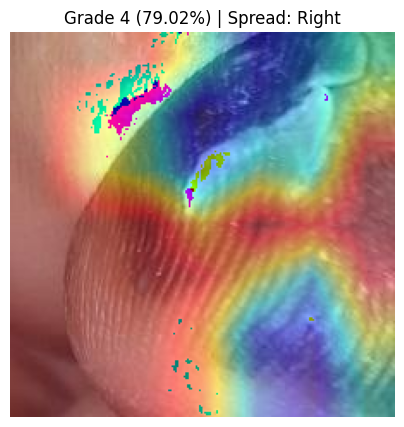

🩺 Predicted Grade      : Grade 4
📊 Confidence Score    : 79.02%
📍 Spreading Direction : Right

🔍 Grade Probabilities:
  Grade 1: 11.12%
  Grade 2: 4.91%
  Grade 3: 4.95%
  Grade 4: 79.02%


In [ ]:
predict_dfu("/content/dfu_data/archive (5)/test/Grade 4/207_jpg.rf.5d5a48f9306bbbe2beec176368251fed.jpg")

In [ ]:
dfu_model.save("/content/dfu_densenet_model.h5")


In [ ]:
from google.colab import files

files.download("/content/dfu_densenet_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json

class_map = train_data.class_indices
with open("/content/class_map.json", "w") as f:
    json.dump(class_map, f)

files.download("/content/class_map.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>